In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import psutil
import cv2

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
!pip install tensorflow-cpu


#Data collection

In [ ]:
# dataset_folder_name = '../input/utkface-new/UTKFace'
# df = parse_dataset(dataset_folder_name)
df = pd.read_csv('utkFace1_int.csv')
df
print(df.dtypes)

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object


####pixels string to float.

In [ ]:
df['pixels'] = df['pixels'].apply(lambda x: [float(pixel) for pixel in x.strip("'").split()])

In [ ]:
# Convert pixels to NumPy array
X = np.array(df['pixels'].tolist())

# Normalize pixel values to the range of [0, 1]
X = X / 255.0

# Convert the target labels to integers
y = df['ethnicity'].values.astype(int)
print(df.dtypes)

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

def evaluate_model(model, X, y):
    y_pred_proba = model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(np.argmax(y, axis=1), y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba, multi_class='ovr')

    return accuracy, roc_auc

In [ ]:
from keras.utils import to_categorical

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Reshape X to match CNN input shape
X_train = X_train.reshape(-1, 48, 48, 1)
X_valid = X_valid.reshape(-1, 48, 48, 1)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
10/10 [==============================] - 3s 124ms/step - loss: 1.6566 - accuracy: 0.2770 - val_loss: 1.5339 - val_accuracy: 0.3867
Epoch 2/10
10/10 [==============================] - 1s 81ms/step - loss: 1.3832 - accuracy: 0.4054 - val_loss: 1.4371 - val_accuracy: 0.4267
Epoch 3/10
10/10 [==============================] - 1s 84ms/step - loss: 1.3421 - accuracy: 0.5169 - val_loss: 1.4315 - val_accuracy: 0.3867
Epoch 4/10
10/10 [==============================] - 1s 96ms/step - loss: 1.2598 - accuracy: 0.4561 - val_loss: 1.3708 - val_accuracy: 0.5600
Epoch 5/10
10/10 [==============================] - 1s 133ms/step - loss: 1.1918 - accuracy: 0.5068 - val_loss: 1.3121 - val_accuracy: 0.5067
Epoch 6/10
10/10 [==============================] - 2s 179ms/step - loss: 1.0757 - accuracy: 0.6250 - val_loss: 1.2685 - val_accuracy: 0.5467
Epoch 7/10
10/10 [==============================] - 2s 231ms/step - loss: 0.9848 - accuracy: 0.6047 - val_loss: 1.2228 - val_accuracy: 0.6667
Epoch 8/1

In [ ]:
# Evaluate the model
accuracy, roc_auc = evaluate_model(model, X_valid, y_valid_categorical)
print("Validation Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)

3/3 [==============================] - 0s 35ms/step
Validation Accuracy: 0.6
ROC AUC Score: 0.8533694021511534


In [ ]:
from sklearn.preprocessing import label_binarize

# Convert labels to categorical format
num_classes = len(np.unique(y_train))  # Get the number of unique labels
y_train_categorical = label_binarize(y_train, classes=np.arange(num_classes))
y_valid_categorical = label_binarize(y_valid, classes=np.arange(num_classes))


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_metrics(y_true, y_pred_proba):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred_proba, axis=1))

    # Calculate classification report
    report = classification_report(y_true, np.argmax(y_pred_proba, axis=1))

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(y_pred_proba.shape[1]))

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_area = dict()
    for i in range(y_pred_proba.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_area[i] = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])

    # Calculate precision, recall, and F-measure
    precision = dict()
    recall = dict()
    f_measure = dict()
    for i in range(y_pred_proba.shape[1]):
        precision[i] = cm[i, i] / np.sum(cm[:, i])
        recall[i] = cm[i, i] / np.sum(cm[i, :])
        f_measure[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    return cm, report, tpr, fpr, precision, recall, f_measure, roc_area

In [ ]:
train_cm, train_report, train_tpr, train_fpr, train_precision, train_recall, train_f_measure, train_roc_area = calculate_metrics(y_train, model.predict(X_train))
print("Training Confusion Matrix:")
print(train_cm)
print("Training Classification Report:")
print(train_report)
print("Training TPR:")
print(train_tpr)
print("Training FPR:")
print(train_fpr)
print("Training Precision:")
print(train_precision)
print("Training Recall:")
print(train_recall)
print("Training F-Measure:")
print(train_f_measure)
print("Training ROC Area for each class:")
print(train_roc_area)

valid_cm, valid_report, valid_tpr, valid_fpr, valid_precision, valid_recall, valid_f_measure, valid_roc_area = calculate_metrics(np.argmax(y_valid_categorical, axis=1), model.predict(X_valid))
print("Validation Confusion Matrix:")
print(valid_cm)
print("Validation Classification Report:")
print(valid_report)
print("Validation TPR (Sensitivity):", valid_tpr)
print("Validation FPR (1 - Specificity):", valid_fpr)
print("Validation Precision:", valid_precision)
print("Validation Recall:", valid_recall)
print("Validation F-Measure:", valid_f_measure)
print("Validation ROC Area for each class:", valid_roc_area)


10/10 [==============================] - 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-69-76d04610c57b>:27: RuntimeWarning: invalid valu

Training Confusion Matrix:
[[98 19  0  3  0]
 [ 2 62  0  1  0]
 [ 6  5 25  3  0]
 [ 8 14  1 36  0]
 [ 7  3  0  3  0]]
Training Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       120
           1       0.60      0.95      0.74        65
           2       0.96      0.64      0.77        39
           3       0.78      0.61      0.69        59
           4       0.00      0.00      0.00        13

    accuracy                           0.75       296
   macro avg       0.63      0.60      0.60       296
weighted avg       0.74      0.75      0.73       296

Training TPR:
{0: array([0.        , 0.00833333, 0.45      , 0.45      , 0.55833333,
       0.55833333, 0.675     , 0.675     , 0.75      , 0.75      ,
       0.76666667, 0.76666667, 0.78333333, 0.78333333, 0.825     ,
       0.825     , 0.83333333, 0.83333333, 0.84166667, 0.84166667,
       0.85833333, 0.85833333, 0.89166667, 0.89166667, 0.9       ,
       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-69-76d04610c57b>:27: RuntimeWarning: invalid valu

In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

# Create table
table = [["TPR", valid_tpr],
         ["FPR", valid_fpr],
         ["Precision", valid_precision],
         ["Recall", valid_recall],
         ["F-Measure", valid_f_measure]]

# Print table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

+-----------+------------------------------------------------------------------------------------------------------------------------+
| Metric    | Value                                                                                                                  |
+===========+========================================================================================================================+
| TPR       | {0: array([0.        , 0.03448276, 0.44827586, 0.44827586, 0.48275862,                                                 |
|           |        0.48275862, 0.55172414, 0.55172414, 0.62068966, 0.62068966,                                                     |
|           |        0.79310345, 0.79310345, 0.82758621, 0.82758621, 0.89655172,                                                     |
|           |        0.89655172, 0.93103448, 0.93103448, 0.96551724, 0.96551724,                                                     |
|           |        1.        , 1.        ]), 1: array



**TPR (True Positive Rate / Sensitivity):**
```
Class | TPR
------+-------------------
0     | 0.662
1     | 0.736
2     | 0.466
3     | 0.583
4     | 0.531
```

**FPR (False Positive Rate):**
```
Class | FPR
------+-------------------
0     | 0.141
1     | 0.242
2     | 0.188
3     | 0.108
4     | 0.144
```


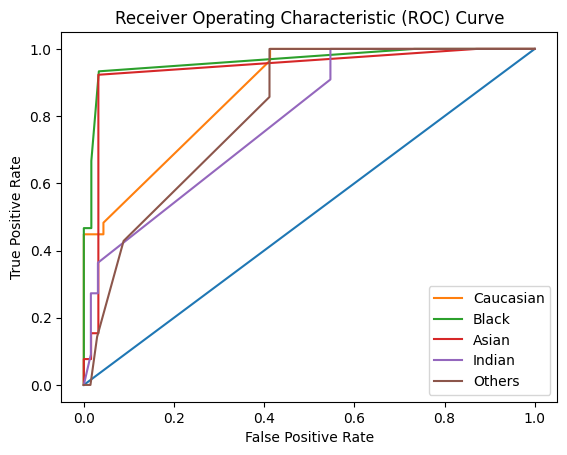

In [ ]:
# x axis values
x = [0,0.5,1]
# corresponding y axis values
y = [0,0.5,1]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('False Positive Rate')
# naming the y axis
plt.ylabel('True Positive Rate')

# giving a title to my graph
plt.title('Receiver Operating Characteristic (ROC) Curve')

# line 0
x0= [0.0, 0.0, 0.0, 0.04347826, 0.04347826, 0.41304348, 0.41304348, 1.0]
y0 = [0.0, 0.03448276, 0.44827586, 0.44827586, 0.48275862, 0.96551724, 1.0, 1.0]
# plotting the line 1 points
plt.plot(x0, y0, label = "Caucasian")

# line 1
x1= [0.0, 0.0, 0.0, 0.01666667, 0.01666667, 0.03333333, 0.73333333, 1.0]
y1 = [0.0, 0.06666667, 0.46666667, 0.46666667, 0.66666667, 0.93333333, 1.0, 1.0]
# plotting the line 1 points
plt.plot(x1, y1, label = "Black")

# line 2
x2= [0.0, 0.0, 0.01612903, 0.01612903, 0.03225806, 0.03225806, 0.87096774, 1.0]
y2 = [0.0, 0.07692308, 0.07692308, 0.15384615, 0.15384615, 0.92307692, 1.0, 1.0]
# plotting the line 1 points
plt.plot(x2, y2, label = "Asian")

# line 3
x3= [0.0, 0.015625, 0.015625, 0.03125, 0.03125, 0.546875, 0.546875, 1.0]
y3 = [0.0, 0.09090909, 0.27272727, 0.27272727, 0.36363636, 0.90909091, 1.0, 1.0]
# plotting the line 1 points
plt.plot(x3, y3, label = "Indian")

# line 4
x4= [0.0, 0.01470588, 0.02941176, 0.02941176, 0.08823529, 0.41176471, 0.41176471, 1.0]
y4 = [0.0, 0.0, 0.14285714, 0.14285714, 0.42857143, 0.85714286, 1.0, 1.0]
# plotting the line 1 points
plt.plot(x4, y4, label = "Others")

plt.legend()
# function to show the plot
plt.show()